In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
global_transformations = [oo.ImputationTransformer(),
                          oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                        custom_function=column_log),
                          oo.CenterScaleTransformer(),
                          oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

In [5]:
params_dict = dict(
                    n_estimators=[1500, 1750, 2000],
                    max_depth=[3, 4, 5],
                    min_child_weight=[1, 2, 3],
                    subsample=[0.90, 0.95, 1],
)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,n_estimators,max_depth,min_child_weight,subsample
0,1500,3,1,0.90
1,1500,3,1,0.95
2,1500,3,1,1.00
3,1500,3,2,0.90
4,1500,3,2,0.95
5,1500,3,2,1.00
6,1500,3,3,0.90
7,1500,3,3,0.95
8,1500,3,3,1.00
9,1500,4,1,0.90


In [6]:
n_positive = np.sum(explore.dataset[target_variable] == positive_class)
n_negative = np.sum(explore.dataset.income == negative_class)
scale_pos_weight_calc = n_negative / n_positive
scale_pos_weight_calc

3.034796573875803

In [7]:
hyper_param_object = oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.05,
                                n_estimators=1500,
                                max_depth=4,
                                min_child_weight=3,
                                gamma=0.1,
                                subsample=0.95,
                                colsample_bytree=0.15,
                                reg_alpha=0.005,
                                scale_pos_weight=scale_pos_weight_calc,)

In [8]:
model=oo.XGBoostClassifier()

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_XGB'
resampler_cache_directory = 'tuner_XGB_resample_cache'

In [11]:
score_list = [BinaryAucRocScore(positive_class=positive_class, threshold=0.5),
              oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      parallelization_cores=-1,
                      #parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [14]:
tuner.results.best_hyper_params

{'n_estimators': 1750, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 1.0}

In [15]:
tuner.results.best_model_resampler_object.score_means

{'BINARY_AUC': 0.8457153054881816,
 'AUC_ROC': 0.9297213921879113,
 'F_BETA': 0.6565762775126679,
 'sensitivity': 0.8673808546152647,
 'positive_predictive_value': 0.6189823694407532}

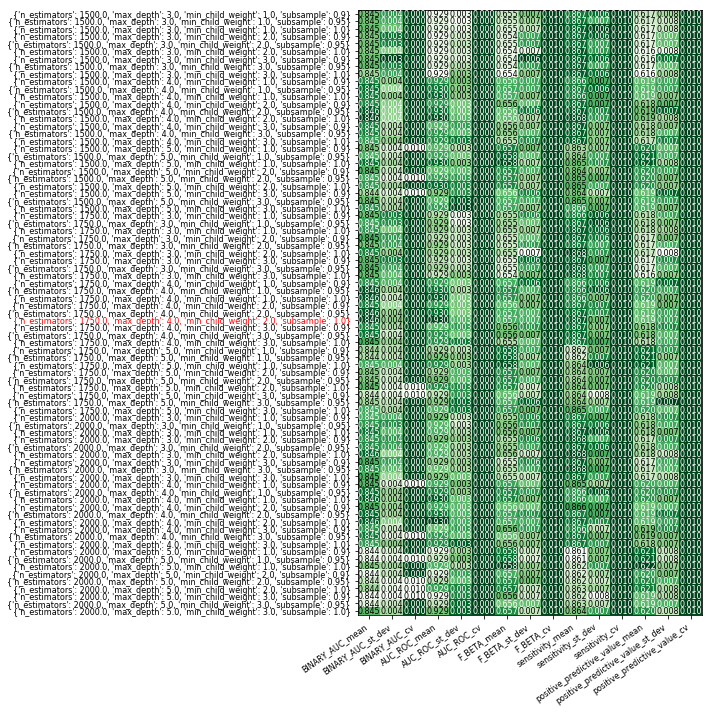

In [16]:
tuner.results.plot_resampled_stats()

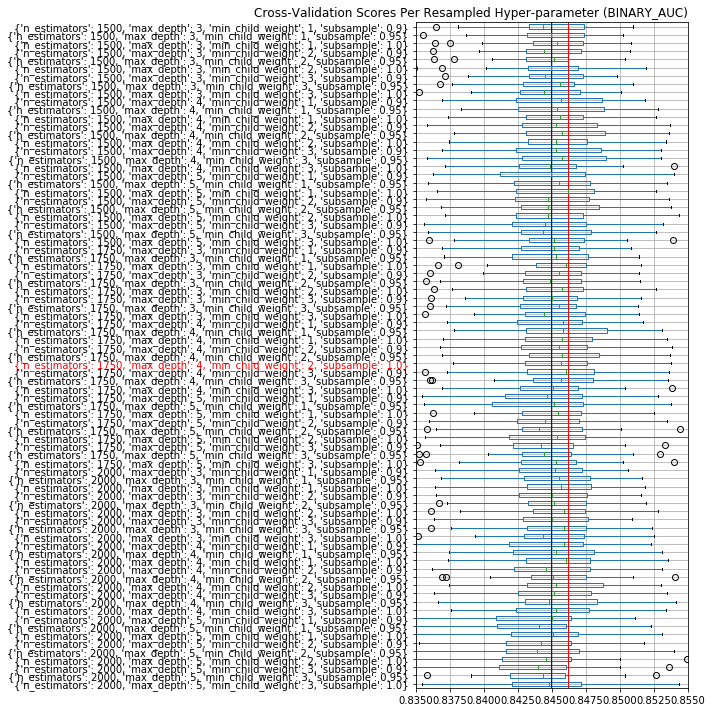

In [17]:
tuner.results.plot_resampled_scores(score_name='BINARY_AUC',
                                    x_axis_limits=(0.835, 0.855),
                                    show_one_ste_rule=True
                                   )

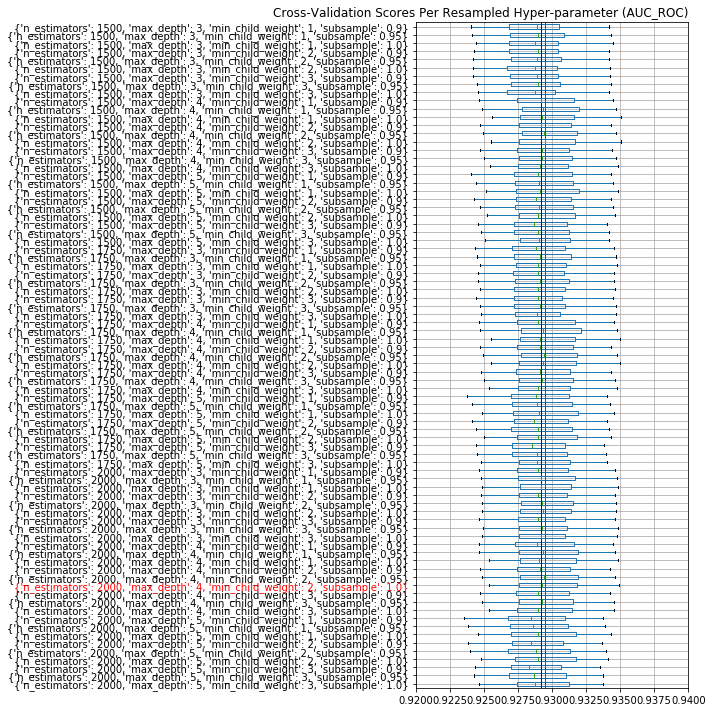

In [18]:
tuner.results.plot_resampled_scores(metric=oo.Metric.AUC_ROC,
                                    x_axis_limits=(0.92, 0.94),
                                    show_one_ste_rule=True
                                   )

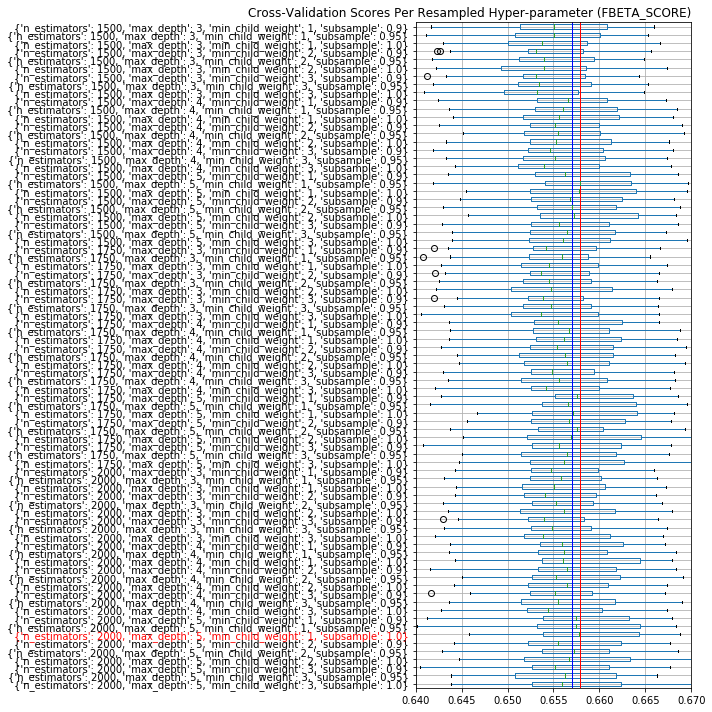

In [19]:
tuner.results.plot_resampled_scores(oo.Metric.FBETA_SCORE,
                                    x_axis_limits=(0.64, 0.67),
                                    show_one_ste_rule=True
                                   )

In [20]:
params_dict

{'n_estimators': [1500, 1750, 2000],
 'max_depth': [3, 4, 5],
 'min_child_weight': [1, 2, 3],
 'subsample': [0.9, 0.95, 1]}

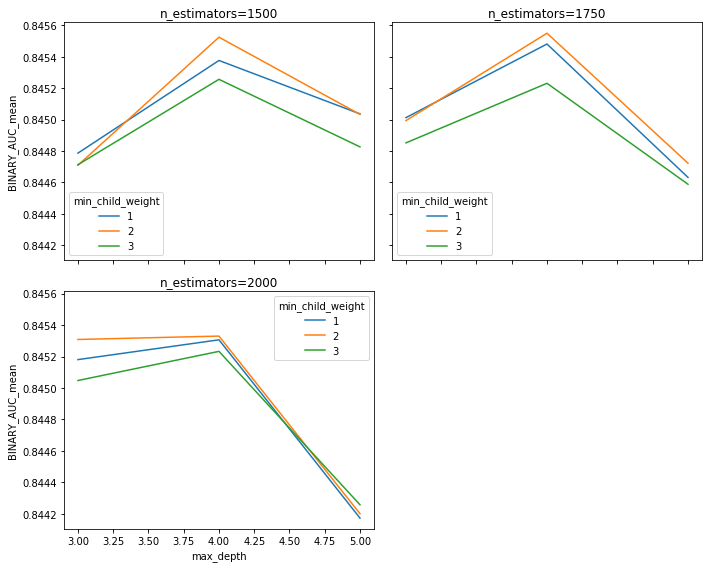

In [21]:
tuner.results.plot_hyper_params_profile(score_name='BINARY_AUC',
                                        x_axis='max_depth',
                                        line='min_child_weight',
                                        grid='n_estimators')

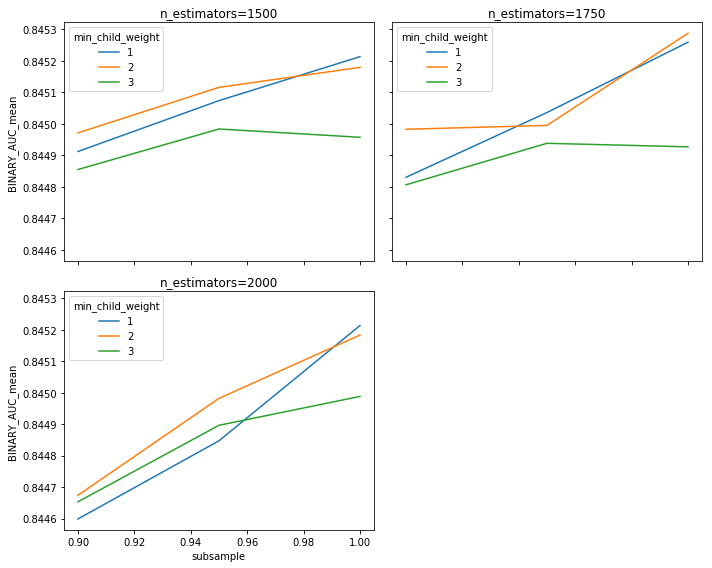

In [22]:
tuner.results.plot_hyper_params_profile(score_name='BINARY_AUC',
                                        x_axis='subsample',
                                        line='min_child_weight',
                                        grid='n_estimators')

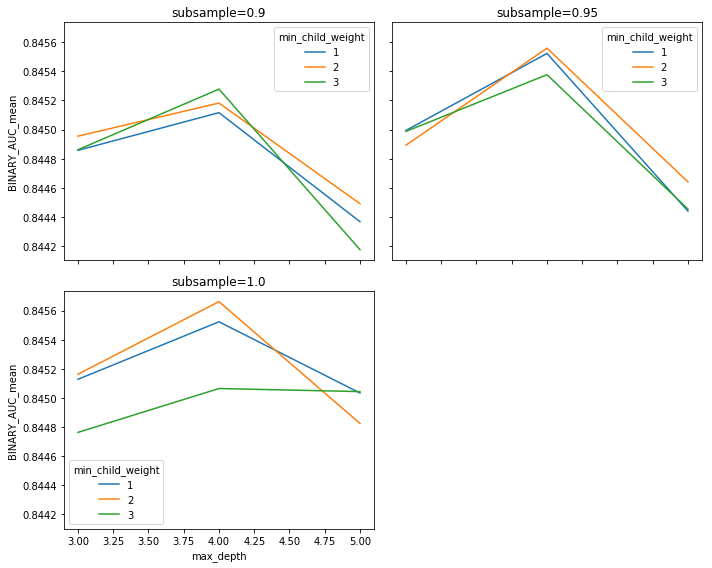

In [23]:
tuner.results.plot_hyper_params_profile(score_name='BINARY_AUC',
                                        x_axis='max_depth',
                                        line='min_child_weight',
                                        grid='subsample')

In [24]:
assert False

AssertionError: 

# Resample Ideal Threshold

In [34]:
final_hyper_param_object = oo.XGBoostTreeHP(
                                    objective=oo.XGBObjective.BINARY_LOGISTIC,
                                    learning_rate=0.05,
                                    n_estimators=1750,
                                    max_depth=4,
                                    min_child_weight=2,
                                    gamma=0.1,
                                    subsample=1.0,
                                    colsample_bytree=0.15,
                                    reg_alpha=0.005,
                                    scale_pos_weight=scale_pos_weight_calc,)

final_model = oo.XGBoostClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [35]:
decorator = oo.TwoClassThresholdDecorator(parallelization_cores=0)
resampler = oo.RepeatedCrossValidationResampler(
    model=final_model.clone(),
    transformations=[t.clone() for t in final_transformations],
    scores=[s.clone() for s in score_list],
    folds=5,
    repeats=2,
    fold_decorators=[decorator])
resampler.resample(data_x=explore.dataset.drop(columns=target_variable),
                   data_y=explore.dataset[target_variable],
                   hyper_params=final_hyper_param_object.clone())
decorator.roc_ideal_thresholds

[0.51, 0.53, 0.49, 0.55, 0.5, 0.48, 0.5, 0.53, 0.5, 0.51]

In [40]:
np.mean(decorator.roc_ideal_thresholds)

0.51

In [41]:
np.median(decorator.roc_ideal_thresholds)

0.505

In [36]:
ideal_threshold = np.mean(decorator.roc_ideal_thresholds)
ideal_threshold

0.51

In [37]:
# use the ideal threshold for the evaluator in order to view ROC
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(threshold=ideal_threshold,  # ideal threshold
                                                  positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train(data=explore.dataset, target_variable=target_variable, hyper_params=final_hyper_param_object.clone())

trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9396792982479776,
 'AUC Precision/Recall': 0.8535702989579598,
 'Kappa': 0.633672267169334,
 'F1 Score': 0.7390033720494568,
 'Two-Class Accuracy': 0.8459599310070319,
 'Error Rate': 0.15404006899296802,
 'True Positive Rate': 0.8799072091363311,
 'True Negative Rate': 0.8347739166225672,
 'False Positive Rate': 0.16522608337743283,
 'False Negative Rate': 0.12009279086366881,
 'Positive Predictive Value': 0.6369978039013048,
 'Negative Predictive Value': 0.9547410894418292,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [42]:
trainer.training_scores[0].value

0.8579816186659002

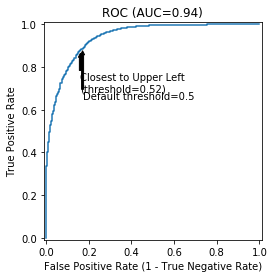

In [39]:
trainer.training_evaluator.plot_roc_curve()

In [43]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [51]:
test_dataset.head(100)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [70]:
indexes = test_dataset['Unnamed: 0']

predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
test_converter = oo.TwoClassThresholdConverter(threshold=0.49, #ideal_threshold,  # ideal thresholds
                                               positive_class=positive_class)
predictions.head()

,<=50K,>50K
0,0.948010,0.051990
1,0.108997,0.891003
2,0.528283,0.471717
3,0.000392,0.999608
4,0.868448,0.131552


In [67]:
class_predictions = test_converter.convert(predictions)
class_predictions[0:5]

array(['<=50K', '>50K', '<=50K', '>50K', '<=50K'], dtype='<U5')

In [71]:
previous_predictions = pd.read_csv('submission_5_xgb.csv')
previous_predictions.head(10)

,id,income
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,1


In [68]:
income_value = [0 if x == '<=50K' else 1 for x in class_predictions]
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_6_xgb.csv', index=False)

In [69]:
# e.g. lower threshold will change 0's to 1's so new - previous will give number predictions that changed to 1
difference = new_predictions.income - previous_predictions.income
difference.sum() / len(difference)

0.014970589536066517

# Results

## 1)

Kaggle Public: `0.89605`

File: `submission_4_xgb.csv`

Parameters: 
```
learning_rate=0.3,
n_estimators=1000,
max_depth=4,
min_child_weight=3,
gamma=0.1,
subsample=0.8,
colsample_bytree=0.8,
scale_pos_weight=scale_pos_weight_calc,
```

Originally had Mean Resampler Results of:

```
{'BINARY_AUC': 0.8433410426212617,
 'AUC_ROC': 0.9272811731616264,
 'F_BETA': 0.6513894746057892,
 'sensitivity': 0.8668096351059255,
 'positive_predictive_value': 0.6133051758501008}
```

## 2)

Kaggle Public: `0.85769`

File: `submission_5_xgb`

ROC Threshold: `0.51`

Parameters:

```
objective=oo.XGBObjective.BINARY_LOGISTIC,
learning_rate=0.05,
n_estimators=1750,
max_depth=4,
min_child_weight=2,
gamma=0.1,
subsample=1.0,
colsample_bytree=0.15,
reg_alpha=0.005,
scale_pos_weight=scale_pos_weight_calc
```

Originally had Mean Resampler Results of:

```
{'BINARY_AUC': 0.8457153054881816,
 'AUC_ROC': 0.9297213921879113,
 'F_BETA': 0.6565762775126679,
 'sensitivity': 0.8673808546152647,
 'positive_predictive_value': 0.6189823694407532}
```


In [ ]:
Kaggle Public: ``

File: `submission_6_xgb`

ROC Threshold: `0.49`

Parameters:

```
objective=oo.XGBObjective.BINARY_LOGISTIC,
learning_rate=0.05,
n_estimators=1750,
max_depth=4,
min_child_weight=2,
gamma=0.1,
subsample=1.0,
colsample_bytree=0.15,
reg_alpha=0.005,
scale_pos_weight=scale_pos_weight_calc
```

Originally had Mean Resampler Results of:

```
{'BINARY_AUC': 0.8457153054881816,
 'AUC_ROC': 0.9297213921879113,
 'F_BETA': 0.6565762775126679,
 'sensitivity': 0.8673808546152647,
 'positive_predictive_value': 0.6189823694407532}
```
